In [1]:
# General Imports
import numpy as np
import skimage.io as io
import pylab
import os
import time
import sys
import random
import cv2
import json
import math
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [3]:
# Imports keras and tensorflow
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [4]:
random.seed(2019)

## **Load Data**



In [5]:
# Set root directory and file paths 
ROOT_DIR = 'drive/My Drive/corrosion_project/'
DATA_DIR = ROOT_DIR + 'preprocessed_data/'
image_files = os.listdir(DATA_DIR + 'images')
label_files = os.listdir(DATA_DIR + 'labels')
bbox_files = os.listdir(DATA_DIR + 'bboxes')

In [6]:
image_files.sort(key = lambda x: int(x.split('.')[0].split('_')[-1]))
label_files.sort(key = lambda x: int(x.split('.')[0].split('_')[-1]))
bbox_files.sort(key = lambda x: int(x.split('.')[0].split('_')[-1]))

In [7]:
def load_one_image(image_path, mask_path, image_size):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image , (image_size , image_size)) # resizing before inserting to the network

    mask = cv2.imread(mask_path , -1)
    mask = cv2.resize(mask , (image_size , image_size))
    mask = mask.reshape((image_size , image_size))
  
    # normalize image
    # image = image / 255.0
    # mask = mask / 255.0

    return image , mask

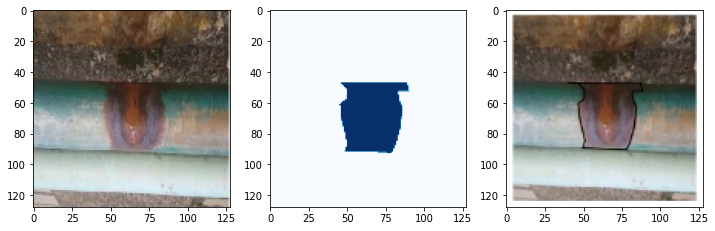

In [8]:
# Show data examples
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
idx = 110 # change index to see examples
image_path = DATA_DIR + 'images/' + image_files[idx]
mask_path = DATA_DIR + 'labels/' + label_files[idx]
img, mask = load_one_image(image_path, mask_path, 128)
axes[0].imshow(img)
axes[1].imshow(mask, cmap='Blues')

if 100 < idx < 124:
    bounding = cv2.imread(DATA_DIR + 'bboxes/' + bbox_files[idx - 101])
    bounding = cv2.cvtColor(bounding, cv2.COLOR_BGR2RGB)
    bounding = cv2.resize(bounding , (128, 128))
    bounding = bounding / 255.0
    axes[2].imshow(bounding)

In [20]:
# Load original images and masks
orig_data, orig_mask = [], []

for idx in range(len(image_files)):
    image_path = DATA_DIR + 'images/' + image_files[idx]
    mask_path = DATA_DIR + 'labels/' + label_files[idx]
    img, mask = load_one_image(image_path, mask_path, 128)
    orig_data.append(img)
    orig_mask.append(mask)

### **Data Augmentation**

In [21]:
# Underwater types
Type_I=[0.805, 0.961, 0.982]

Type_IA=[0.804, 0.955, 0.975]

Type_IB=[0.830, 0.950, 0.968]

Type_II=[0.800, 0.925, 0.940]

Type_III=[0.750, 0.885, 0.89]

Type_1=[0.750, 0.885, 0.875]

Type_3=[0.710, 0.820, 0.800]

Type_5=[0.670, 0.730, 0.670]

Type_7=[0.620, 0.610, 0.500]

Type_9=[0.550, 0.460, 0.290]

In [22]:
medias = [Type_I, Type_IA, Type_IB, Type_II, Type_III, Type_1, Type_3, Type_5, Type_7, Type_9]
labels = ['image', 'depth map', 'Type_I', 'Type_IA', 'Type_IB', 'Type_II', 
          'Type_III', 'Type_1', 'Type_3', 'Type_5', 'Type_7', 'Type_9']

In [33]:
def generate_underwater_img(img, distance):
    img = img
    depth_array = np.ones((128, 128)) * distance
    underwater_imgs = []

    for media in medias:
        energy_ratio = []
        for beta in media:
            ratio = np.power(beta, depth_array)
            energy_ratio.append(ratio)
        energy_ratio = np.transpose(np.array(energy_ratio), (1, 2, 0))
        underwater = np.multiply(img, energy_ratio) + background * (1 - energy_ratio)
        underwater = underwater / 255
        underwater_imgs.append(underwater)
    
    return underwater_imgs

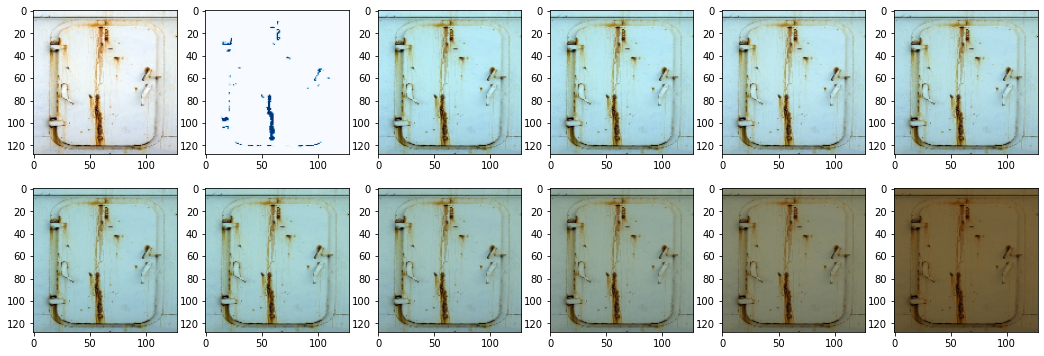

In [34]:
# Check underwater example
background = random.uniform(0.8, 1)
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
idx = 3
orig_img = orig_data[idx]
orig_label = orig_mask[idx]

underwater_imgs = generate_underwater_img(orig_img, 1.2)

axes.flat[0].imshow(orig_img)
axes.flat[1].imshow(orig_label, cmap='Blues')

for i in range(len(underwater_imgs)):
    img = underwater_imgs[i]
    axes.flat[i+2].imshow(img)

fig.savefig('underwater_example.png', dpi=300)

In [45]:
# Create a list containing augmented images
def data_augmentation(orig_img, label):
    all_img = [orig_img/255]
    flip_1 = cv2.flip(orig_img, 0)/255
    flip_2 = cv2.flip(orig_img, 1)/255
    flip_3 = cv2.flip(orig_img, -1)/255
    rotate_1 = cv2.rotate(orig_img, cv2.ROTATE_90_CLOCKWISE)/255
    rotate_2 = cv2.rotate(orig_img, cv2.ROTATE_90_COUNTERCLOCKWISE)/255

    all_img.append(flip_1)
    all_img.append(flip_2)
    all_img.append(flip_3)
    all_img.append(rotate_1)
    all_img.append(rotate_2) 

    if label is False:
        blur_img = cv2.blur(orig_img,(10, 10)) / 255
        gaussian = np.random.normal(0, 0.4, (orig_img.shape[0], orig_img.shape[1])).reshape(128, 128, 1) 
        noisy_img = orig_img / 255 + gaussian
        noisy_img = np.clip(noisy_img, 0, 1)
        all_img.append(blur_img.reshape(128, 128, orig_img.shape[2]))
        all_img.append(noisy_img.reshape(128, 128, orig_img.shape[2]))
        underwater_imgs_1 = generate_underwater_img(orig_img, distance=0.5)
        underwater_imgs_2 = generate_underwater_img(orig_img, distance=1.2)
        all_img += underwater_imgs_1
        all_img += underwater_imgs_2
    else:
        all_img.append(orig_img/255)
        all_img.append(orig_img/255)
        all_img += [orig_img/255] * (len(medias) * 2)

    return all_img

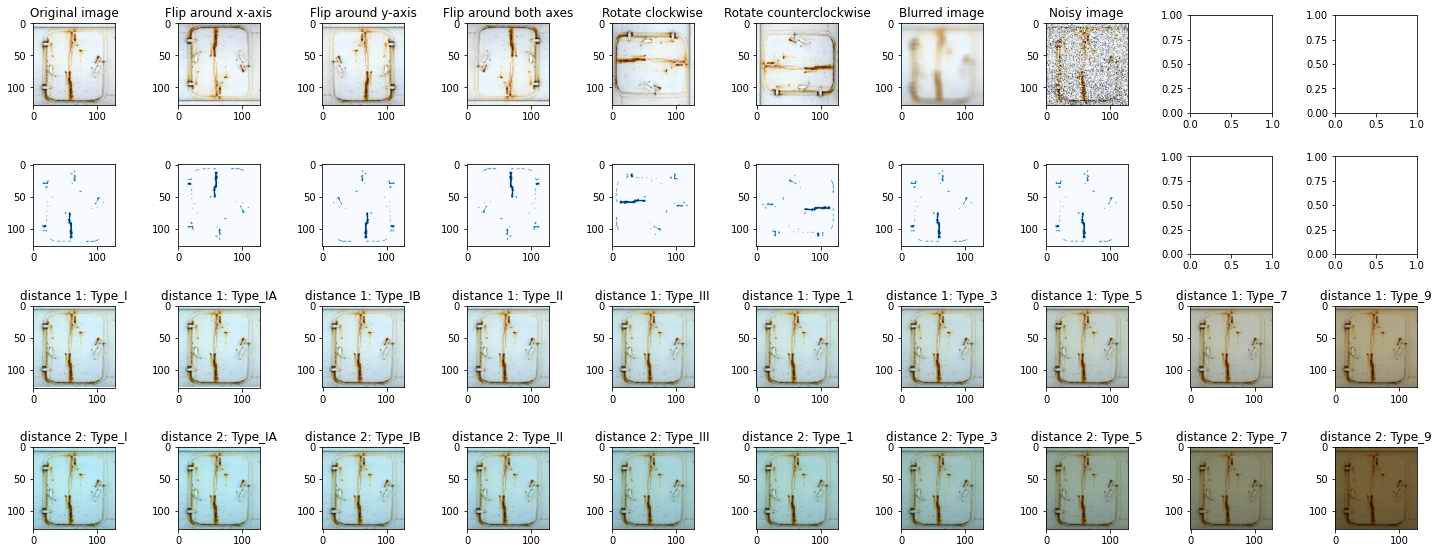

In [46]:
# Show one augmented example
idx = 3
orig_img = orig_data[idx]
orig_label = orig_mask[idx]

augmented_img = data_augmentation(orig_img, label=False)
augmented_label = data_augmentation(orig_label, label=True)
sub_titles = ['Original image', 'Flip around x-axis', 'Flip around y-axis', 'Flip around both axes',
              'Rotate clockwise', 'Rotate counterclockwise', 'Blurred image', 'Noisy image']

fig, axes = plt.subplots(4, 10, figsize=(20, 8))

for k in range(8):
    axes[0, k].imshow(augmented_img[k])
    axes[0, k].set_title(sub_titles[k])

for k in range(8):
    axes[1, k].imshow(augmented_label[k], cmap='Blues')

for k in range(10):
    axes[2, k].imshow(augmented_img[k + 8])
    axes[2, k].set_title('distance 1: ' + labels[k+2])

for k in range(10):
    axes[3, k].imshow(augmented_img[k + 18])
    axes[3, k].set_title('distance 2: ' + labels[k+2])

fig.tight_layout()
fig.savefig('data_agmentation_example.png', dpi=300)

In [47]:
# Collect all data and labels
all_data, all_labels = [], []
for i in range(len(orig_data)):
    orig_img = np.array(orig_data[i])
    orig_label = np.array(orig_mask[i])
    all_data.append(data_augmentation(orig_img, label=False))
    all_labels.append(data_augmentation(orig_label, label=True))

In [48]:
len(all_labels[0])

28

### **K-fold cross validation data**

In [ ]:
# Prepare for K-fold Cross validation 
K = 5
arr = np.arange(len(all_data))
np.random.shuffle(arr)
num = math.ceil(len(all_data) / K)
cv_groups = [list(arr[i*num: (i+1)*num]) for i in range(K)]

In [ ]:
for group in cv_groups:
    print(len(group))

## **Define U-Net**

In [54]:
def down_block(
    input_tensor,
    no_filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal",
    max_pool_window=(2, 2),
    max_pool_stride=(2, 2)
):
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    # conv for skip connection
    conv = Activation("relu")(conv)

    pool = MaxPooling2D(pool_size=max_pool_window, strides=max_pool_stride)(conv)

    return conv, pool

In [55]:
def bottle_neck(
    input_tensor,
    no_filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal"
):
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    return conv

In [56]:
def up_block(    
    input_tensor,
    no_filters,
    skip_connection, 
    kernel_size=(3, 3),
    strides=(1, 1),
    upsampling_factor = (2,2),
    max_pool_window = (2,2),
    padding="same",
    kernel_initializer="he_normal"):
    
    
    conv = Conv2D(
        filters = no_filters,
        kernel_size= max_pool_window,
        strides = strides,
        activation = None,
        padding = padding,
        kernel_initializer=kernel_initializer
    )(UpSampling2D(size = upsampling_factor)(input_tensor))
    
    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv) 
    
    
    conv = concatenate( [skip_connection , conv]  , axis = -1)
    
    
    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)

    conv = Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)

    conv = BatchNormalization(scale=True)(conv)

    conv = Activation("relu")(conv)
    
    return conv



In [57]:
def output_block(input_tensor,
    padding="same",
    kernel_initializer="he_normal"
):
    
    conv = Conv2D(
        filters=2,
        kernel_size=(3,3),
        strides=(1,1),
        activation="relu",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)
    
    
    conv = Conv2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        activation="sigmoid",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    
    
    return conv
    

In [58]:
def UNet(input_shape = (128,128,3)):
    
    # filter_size = [64,128,256,512,1024]
    filter_size = [16, 32, 64, 128, 256]
    
    inputs = Input(shape = input_shape)
    
    d1 , p1 = down_block(input_tensor= inputs,
                         no_filters=filter_size[0],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    d2 , p2 = down_block(input_tensor= p1,
                         no_filters=filter_size[1],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    
    d3 , p3 = down_block(input_tensor= p2,
                         no_filters=filter_size[2],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    
    d4 , p4 = down_block(input_tensor= p3,
                         no_filters=filter_size[3],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    
    
    b = bottle_neck(input_tensor= p4,
                         no_filters=filter_size[4],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal")
    
    
    
    u4 = up_block(input_tensor = b,
                  no_filters = filter_size[3],
                  skip_connection = d4,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    u3 = up_block(input_tensor = u4,
                  no_filters = filter_size[2],
                  skip_connection = d3,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    u2 = up_block(input_tensor = u3,
                  no_filters = filter_size[1],
                  skip_connection = d2,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    
    
    u1 = up_block(input_tensor = u2,
                  no_filters = filter_size[0],
                  skip_connection = d1,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
     
    output = output_block(input_tensor=u1 , 
                         padding = "same",
                         kernel_initializer= "he_normal")
    
    model = Model(inputs = inputs , outputs = output)
    
    
    return model
    

## **Train and evaluate UNet**

In [59]:
# UNet hyperparameters
image_size = 128 
epochs = 30
batch_size = 16

In [60]:
# One-time run
i = 0
train_group = list(np.arange(K))
test_group = i
train_group.pop(i)

train_data, train_labels, test_data, test_labels = [], [], [], []
for idx in cv_groups[test_group]:
    for j in range(28):
        test_data.append(all_data[idx][j])
        test_labels.append(all_labels[idx][j])

for group in train_group:
    for idx in cv_groups[group]:
        for j in range(28):
            train_data.append(all_data[idx][j])
            train_labels.append(all_labels[idx][j])

X_train = np.array(train_data)
X_test = np.array(test_data)

y_train = np.array(train_labels).astype(int)
y_test = np.array(test_labels).astype(int)

In [61]:
X_test.shape

(700, 128, 128, 3)

In [62]:
# Create instance of model.
model = UNet(input_shape = (image_size,image_size,3))
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Load in pre-trained COCO weights
model.load_weights(ROOT_DIR + 'mask_rcnn_coco.h5', by_name=True)
model.fit(X_train, y_train, epochs=epochs, batch_size=16, verbose=1)

Epoch 1/30
174/174 [==============================] - 595s 3s/step - loss: 0.5232 - accuracy: 0.7825
Epoch 2/30
174/174 [==============================] - 595s 3s/step - loss: 0.3144 - accuracy: 0.8940
Epoch 3/30
174/174 [==============================] - 599s 3s/step - loss: 0.2327 - accuracy: 0.9190
Epoch 4/30
174/174 [==============================] - 599s 3s/step - loss: 0.1926 - accuracy: 0.9309
Epoch 5/30
174/174 [==============================] - 599s 3s/step - loss: 0.1647 - accuracy: 0.9391
Epoch 6/30
174/174 [==============================] - 599s 3s/step - loss: 0.1490 - accuracy: 0.9440
Epoch 7/30
174/174 [==============================] - 598s 3s/step - loss: 0.1345 - accuracy: 0.9485
Epoch 8/30
174/174 [==============================] - 599s 3s/step - loss: 0.1209 - accuracy: 0.9540
Epoch 9/30
174/174 [==============================] - 595s 3s/step - loss: 0.1076 - accuracy: 0.9592
Epoch 10/30
174/174 [==============================] - 593s 3s/step - loss: 0.1021 - accura

In [63]:
# Evaluate UNet performance
def unet_performance(model, X, y):

    tn, fp, fn, tp = 0, 0, 0, 0
    intersection, union = 0, 0
    y_pred = model.predict(X)       
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(int)

    for i in range(X.shape[0]):
        
        # Confusion Matrix
        y_pred_1d = y_pred[i].flatten()
        y_1d = y[i].flatten()
        
        confusion_ravel = confusion_matrix(y_1d, y_pred_1d).ravel()

        cur_tn, cur_fp, cur_fn, cur_tp = confusion_ravel

        cur_intersection = np.logical_and(y_1d, y_pred_1d)
        cur_union = np.logical_or(y_1d, y_pred_1d)
        cur_iou_score = np.sum(cur_intersection) / np.sum(cur_union)

        tn += cur_tn
        fp += cur_fp
        fn += cur_fn
        tp += cur_tp
        intersection += np.sum(cur_intersection)
        union += np.sum(cur_union)
      
        cur_precision = cur_tp / (cur_tp + cur_fp)
        cur_recall = cur_tp / (cur_tp + cur_fn)
        cur_F1 = 2 * (cur_precision * cur_recall) / (cur_precision + cur_recall)
        
    correct = tn + tp
    total = tn + fp + fn + tp
    acc = correct/total
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    iou_score = intersection / union

    return acc, precision, recall, F1, iou_score

In [65]:
# Evaluate train and test performance
a1, p1, r1, f1, iou1 = unet_performance(model, X_train, y_train)
a2, p2, r2, f2, iou2 = unet_performance(model, X_test, y_test)
print('Train accuracy: %.3f, precision: %.3f, recall: %.3f, F1: %.3f, IoU: %.3f' % (a1*100, p1, r1, f1, iou1))
print('Test accuracy: %.3f, precision: %.3f, recall: %.3f, F1: %.3f, IoU: %.3f' % (a2*100, p2, r2, f2, iou2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


Train accuracy: 98.195, precision: 0.954, recall: 0.933, F1: 0.944, IoU: 0.894
Test accuracy: 83.806, precision: 0.717, recall: 0.424, F1: 0.533, IoU: 0.364


In [64]:
# Save best model
model.save('best_UNet_model.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


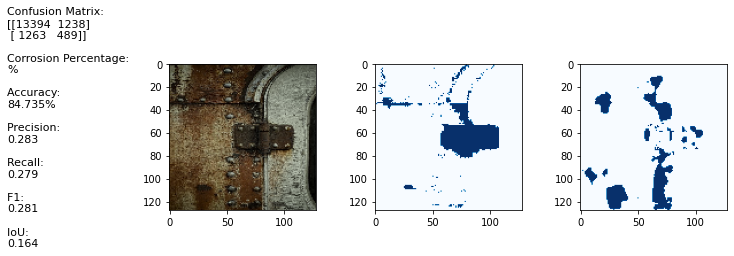

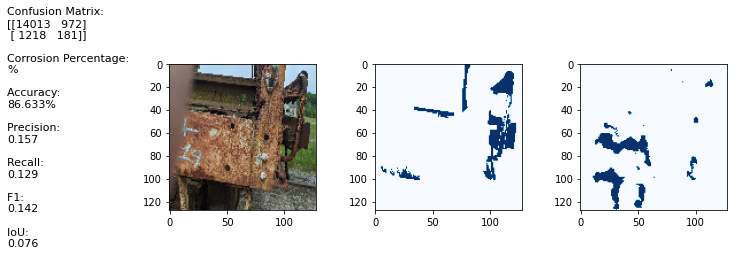

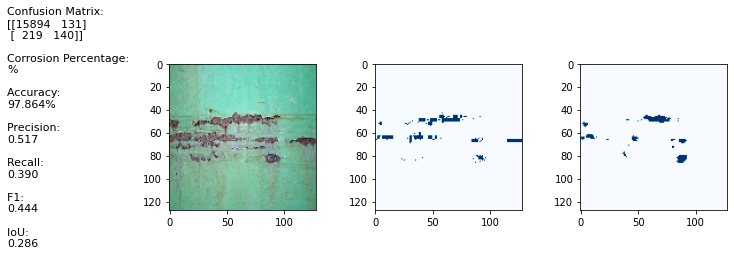

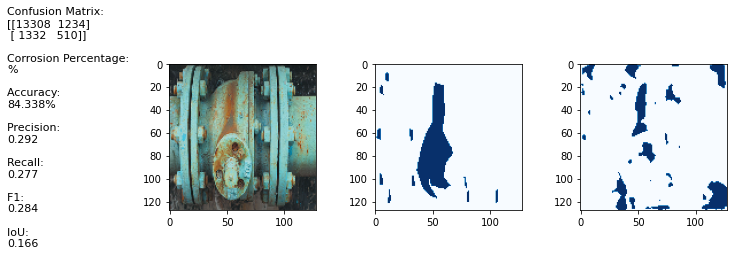

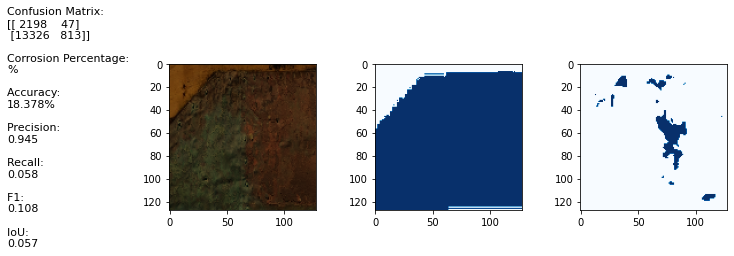

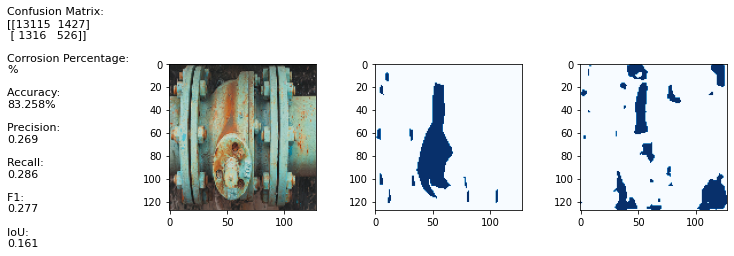

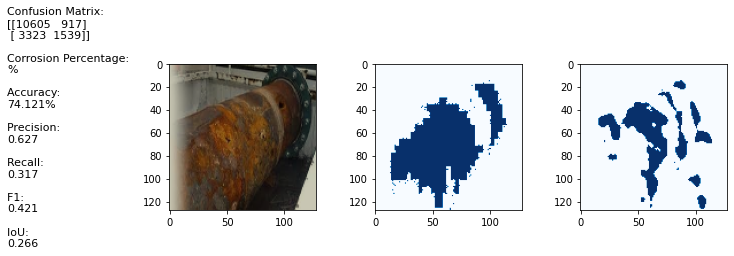

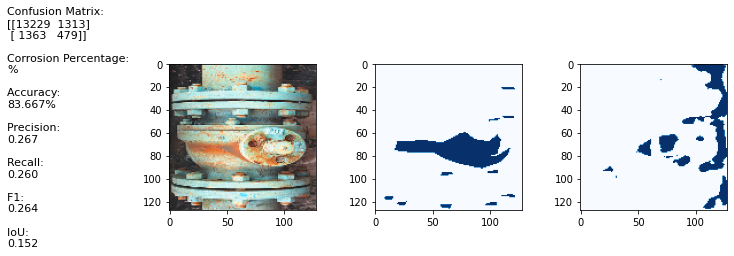

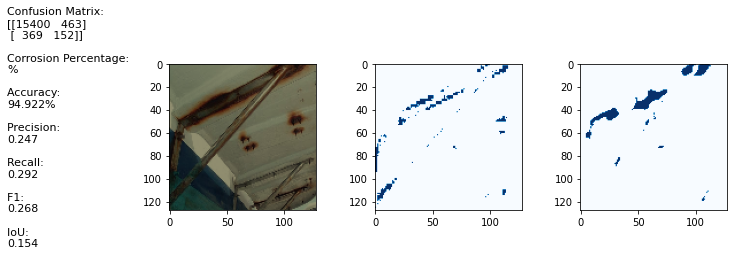

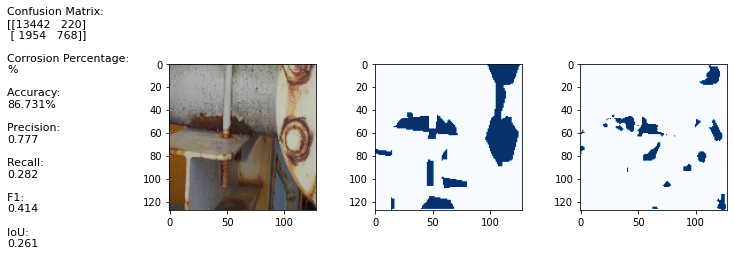

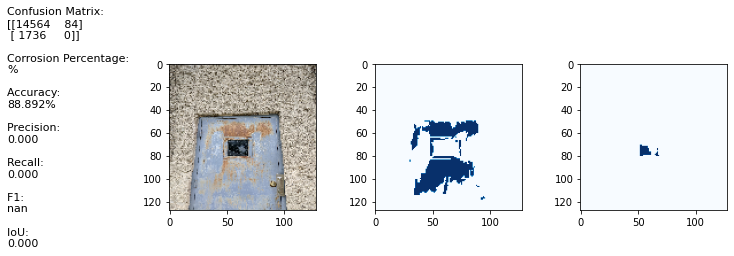

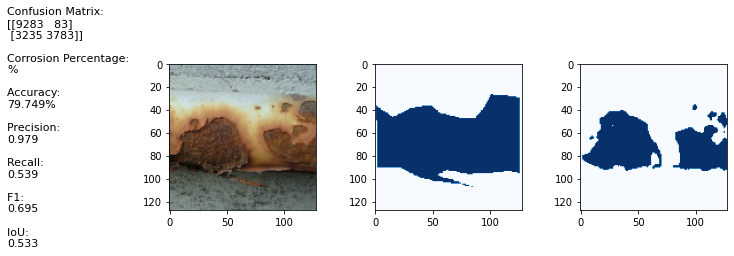

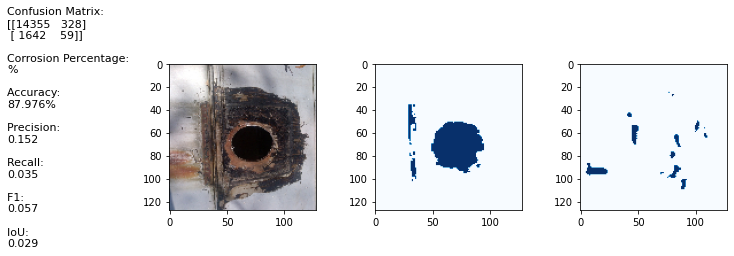

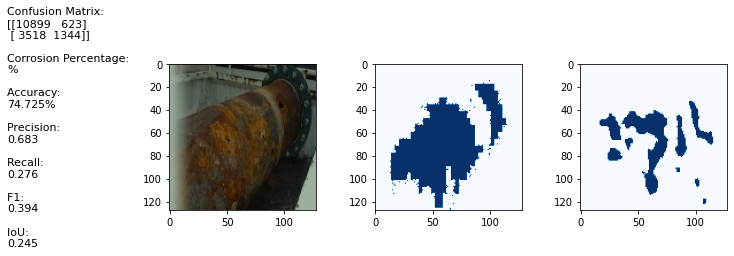

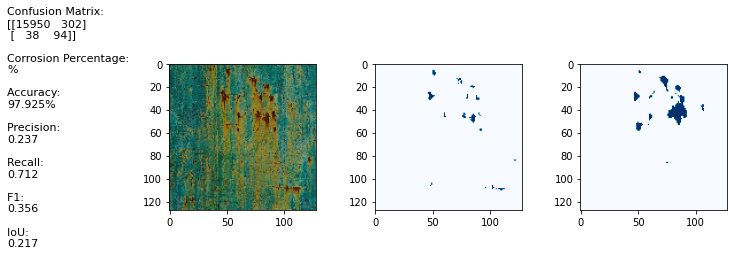

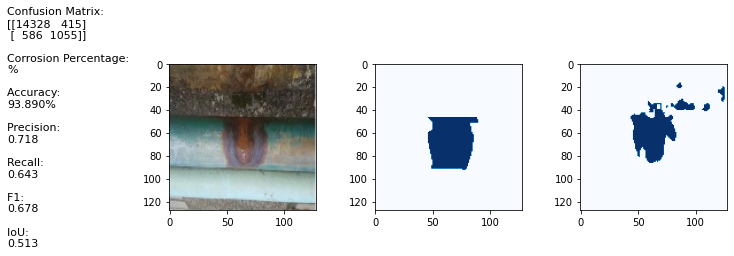

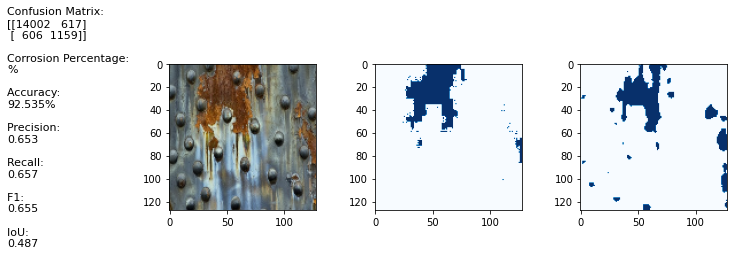

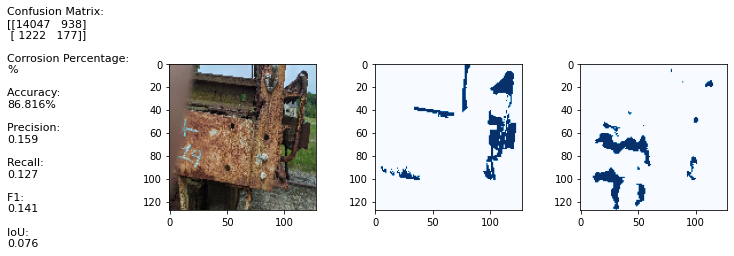

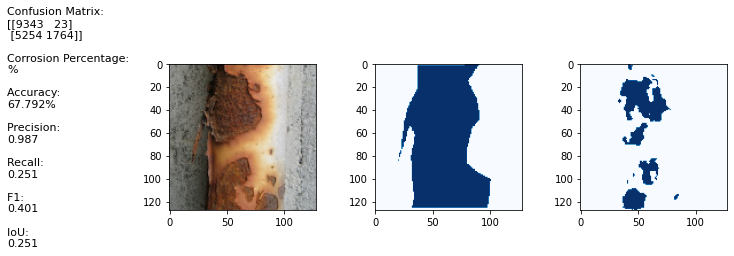

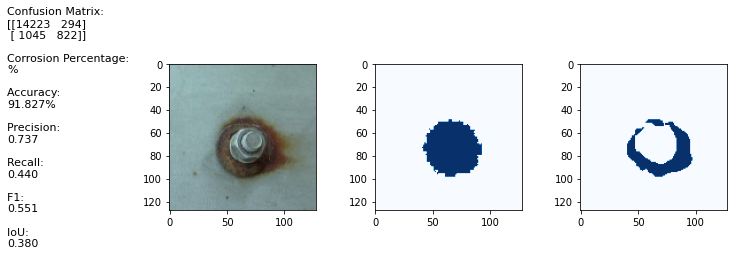

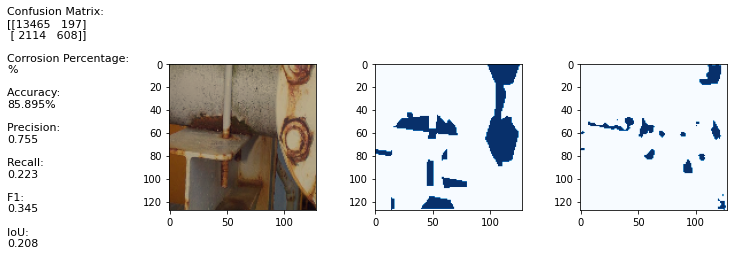

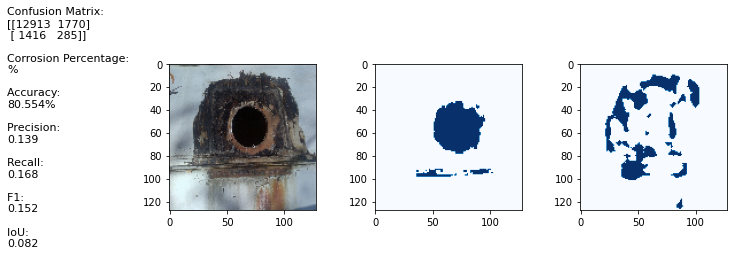

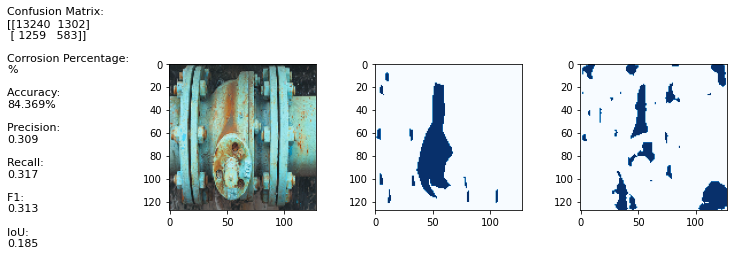

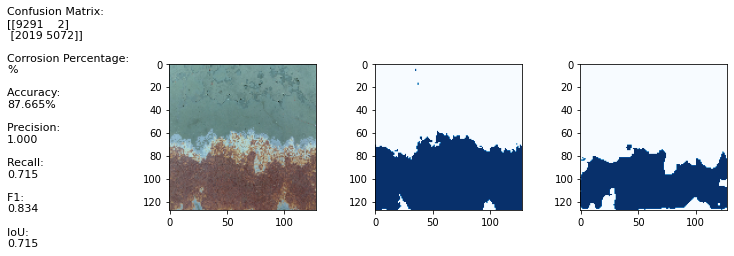

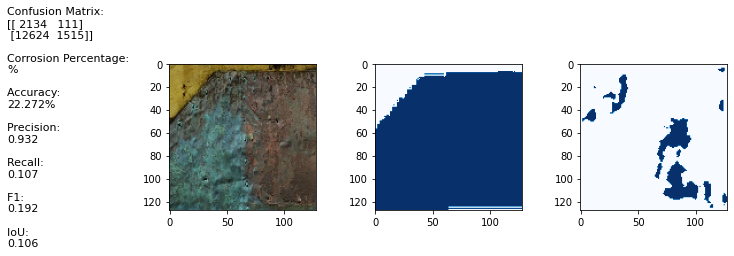

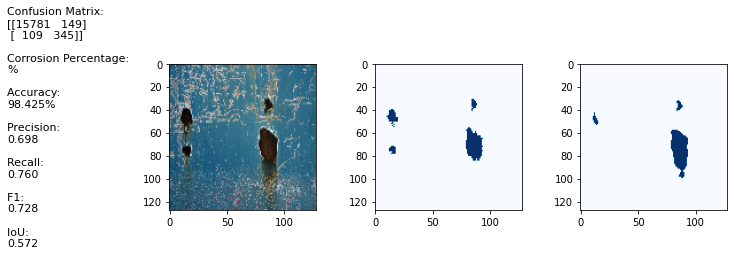

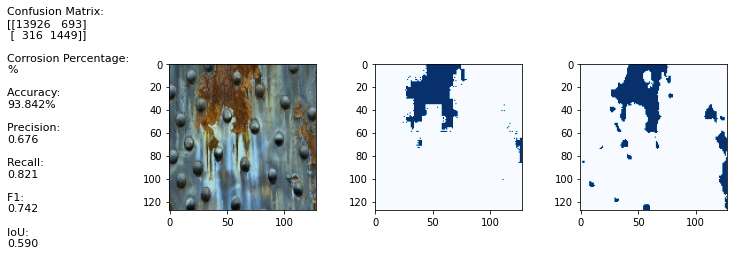

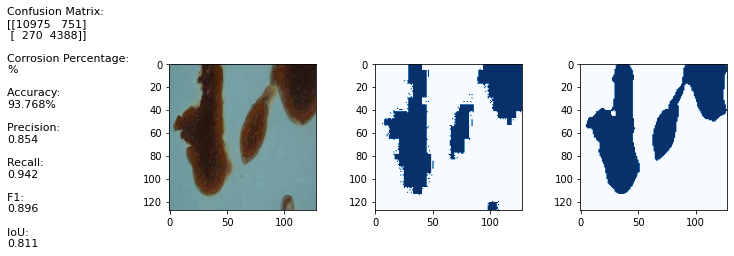

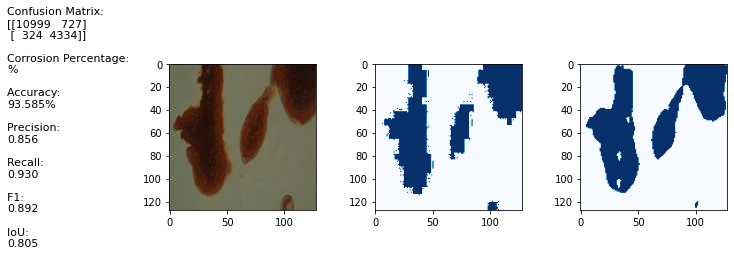

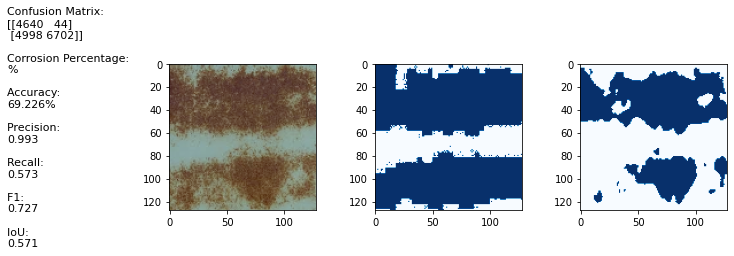

In [70]:
# Check prediction examples
# How many examples want to check? 
num = 30

X, y = shuffle(X_test, y_test)
X, y = X[:num, ], y[:num, ]

y_pred = model.predict(X)       
y_pred = y_pred > 0.5
y_pred = y_pred.astype(int)

for i in range(num):
    
    # Confusion Matrix
    y_pred_1d = y_pred[i].flatten()
    y_1d = y[i].flatten()
    
    cur_cm = confusion_matrix(y_1d, y_pred_1d)

    cur_tn, cur_fp, cur_fn, cur_tp = cur_cm.ravel()

    cur_acc = (cur_tn + cur_tp) / (cur_tn + cur_fp + cur_fn + cur_tp)
    cur_precision = cur_tp / (cur_tp + cur_fp)
    cur_recall = cur_tp / (cur_tp + cur_fn)
    cur_F1 = 2 * (cur_precision * cur_recall) / (cur_precision + cur_recall)

    cur_intersection = np.logical_and(y_1d, y_pred_1d)
    cur_union = np.logical_or(y_1d, y_pred_1d)
    cur_iou_score = np.sum(cur_intersection) / np.sum(cur_union)
       
    # Display results
    width_height_big = (10, 10)

    fig = plt.figure(figsize = width_height_big)
    
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(X[i])

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[i], (image_size, image_size)), cmap="Blues")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(y_pred[i], (image_size, image_size)), cmap="Blues")
    
    
    textstr = "Confusion Matrix: \n" + str(cur_cm) + "\n\nCorrosion Percentage: \n" + "%" + "\n\nAccuracy: \n" + str("{:.3f}".format(cur_acc*100)) + "%" + "\n\nPrecision: \n" + str("{:.3f}".format(cur_precision)) + "\n\nRecall: \n" + str("{:.3f}".format(cur_recall)) + "\n\nF1: \n" + str("{:.3f}".format(cur_F1)) + "\n\nIoU: \n" + str("{:.3f}".format(cur_iou_score))
    ax.text(-0.1, 0.35, textstr, fontsize=11, transform=plt.gcf().transFigure)

In [ ]:
# Unet K-fold cv performance
acc_train, precision_train, recall_train, F1_train, iou_train = [], [], [], [], []
acc_test, precision_test, recall_test, F1_test, iou_test = [], [], [], [], []

for i in range(K):
    # Compile model
    train_group = list(np.arange(K))
    test_group = i
    train_group.pop(i)

    train_data, train_labels, test_data, test_labels = [], [], [], []
    for idx in cv_groups[test_group]:
        for j in range(28):
            test_data.append(all_data[idx][j])
            test_labels.append(all_labels[idx][j])

    for group in train_group:
        for idx in cv_groups[group]:
            for j in range(28):
                train_data.append(all_data[idx][j])
                train_labels.append(all_labels[idx][j])

    X_train = np.array(train_data)
    X_test = np.array(test_data)  
    y_train = np.array(train_labels).astype(int)
    y_test = np.array(test_labels).astype(int)

    model = UNet(input_shape = (image_size,image_size,3))
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.load_weights(ROOT_DIR + 'mask_rcnn_coco.h5', by_name=True)

    # Fit the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, verbose=0)
    # evaluate the model

    a1, p1, r1, f1, iou1 = unet_performance(model, X_train, y_train)
    a2, p2, r2, f2, iou2 = unet_performance(model, X_test, y_test)

    acc_train.append(a1)
    precision_train.append(p1)
    recall_train.append(r1)
    F1_train.append(f1)
    iou_train.append(iou1)

    acc_test.append(a2)
    precision_test.append(p2)
    recall_test.append(r2)
    F1_test.append(f2)
    iou_test.append(iou2)

    print('Fold ' + str(i) + ':')
    print('Train accuracy: %.3f, precision: %.3f, recall: %.3f, F1: %.3f, IoU: %.3f' % (a1*100, p1, r1, f1, iou1))
    print('Test accuracy: %.3f, precision: %.3f, recall: %.3f, F1: %.3f, IoU: %.3f' % (a2*100, p2, r2, f2, iou2))

print('Average performance: ')
print('%.3f, %.3f, %.3f, %.3f, %.3f' % (mean(acc_train)*100, mean(precision_train), mean(recall_train), mean(F1_train), mean(iou_train)))
print('%.3f, %.3f, %.3f, %.3f, %.3f' % (mean(acc_test)*100, mean(precision_test), mean(recall_test), mean(F1_test), mean(iou_test)))